In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
import matplotlib.cm as cm


In [9]:
folder_path_con1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250704/Si_Au/data'
folder_path_con2 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250725/Si_Au/data'

In [10]:
folder_path_1 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250725/Si_Au(island)/data'
folder_path_2 = '/Volumes/CYQ_HD/程业勤/11_IPP_PhD/M1/S3/250725/Si_Au(island)_molecule/data'

In [11]:
def extract_angle(filename):
    # Look for the last number at the end of the filename, even if there's no extension
    match = re.search(r"(\d+(?:\.\d+)?)\s*(?=\s*$|\.\w+$)", filename)
    return float(match.group(1)) if match else None


In [12]:
def extract_data_from_single_file(file_path):
    try:
        # Read comma-separated values
        df = pd.read_csv(file_path, sep=',', header=None, names=['wavenumber', 'R'], encoding='ISO-8859-1')
        return df
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None


In [13]:
# Function to iterate through the folder and extract data for different angles
def read_dpt_files_in_folder(folder_path):
    data = {}
    for file in os.listdir(folder_path):
        angle = extract_angle(file)
        if angle is not None:
            # Construct the full file path
            file_path = os.path.join(folder_path, file)
            # Extract data from the file
            df = extract_data_from_single_file(file_path)
            if df is not None:
                data[angle] = df
        
            
            
    return data

In [14]:
data_y1 = read_dpt_files_in_folder(folder_path_1)
data_y2 = read_dpt_files_in_folder(folder_path_2)
data_y1_con = read_dpt_files_in_folder(folder_path_con1)
data_y2_con = read_dpt_files_in_folder(folder_path_con2)


In [15]:
exp_wavenumbers = data_y1[5]['wavenumber'].values

In [16]:
def compute_normed_ratio(data_y1, data_y2, window):
    data_ratio = {}
    data_ratio_smoothed = {}  # New dictionary for smoothed values

    for angle in data_y1:
        if angle in data_y2:
            df1 = data_y1[angle]
            df2 = data_y2[angle]

            # Ensure wavenumbers match
            if np.allclose(df1['wavenumber'], df2['wavenumber']):
                wn = df1['wavenumber'].values
                R1 = df1['R'].values
                R2 = df2['R'].values

                ratio = np.where(R1 != 0, R2 / R1, np.nan)

                # --- Compute sliding average ---
                ratio_smooth = []
                for i, center_wn in enumerate(wn):
                    # Get mask for points within ±window cm⁻¹
                    mask = (wn >= center_wn - window) & (wn <= center_wn + window)
                    valid = ~np.isnan(ratio[mask])
                    if np.any(valid):
                        avg = np.mean(ratio[mask][valid])
                    else:
                        avg = np.nan
                    ratio_smooth.append(avg)

                # Store raw and smoothed ratio
                df_ratio = pd.DataFrame({
                    'wavenumber': wn,
                    'Normed R': ratio
                })
                df_ratio_smooth = pd.DataFrame({
                    'wavenumber': wn,
                    'Smoothed Normed R': ratio_smooth
                })

                data_ratio[angle-3] = df_ratio
                data_ratio_smoothed[angle-3] = df_ratio_smooth
            else:
                print(f"Wavenumbers do not match at angle {angle}. Skipping.")
        else:
            print(f"Angle {angle} missing in data_y2. Skipping.")

    return data_ratio, data_ratio_smoothed


In [17]:
window = 30
data_normed, data_normed_smoothed = compute_normed_ratio(data_y1, data_y2,window)
data_normed_con, data_normed_smoothed_con = compute_normed_ratio(data_y1_con, data_y2_con,window)



In [18]:
all_angles = []
for i in range(5,51):
    all_angles.append(i)

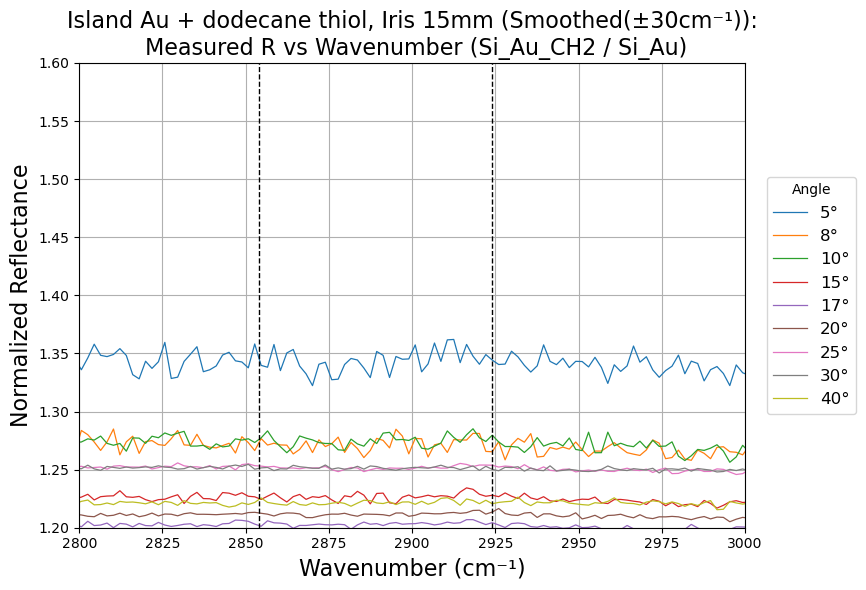

In [19]:
# --- SELECT angles
selected_angles = [5,8, 10, 15, 17, 20, 25, 30, 40,50] 
# selected_angles = all_angles
# selected_angles = anglelist

# --- Plot reflectance vs wavenumber for selected angles ---
plt.figure(figsize=(11, 6))

for angle in selected_angles:
    if angle not in data_normed:
        print(f"Warning: angle {angle}° not found in data_normed.")
        continue

    df = data_normed[angle]
    wavenumbers = df["wavenumber"].values
    reflectance = df["Normed R"].values
    plt.plot(wavenumbers, reflectance, label=f"{angle}°",linewidth=0.9)

plt.title(f"Island Au + dodecane thiol, Iris 15mm (Smoothed(±{window}cm⁻¹)):\n Measured R vs Wavenumber (Si_Au_CH2 / Si_Au)", fontsize = 16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize = 16)
plt.ylabel("Normalized Reflectance", fontsize = 16)
plt.xlim(2800, 3000)
plt.ylim(1.2, 1.6)
plt.axvline(2854, color='black', linestyle='--', linewidth=1)
plt.axvline(2924, color='black', linestyle='--', linewidth=1)
plt.grid(True)
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend
plt.show()


In [20]:
# # --- SELECT angles
# selected_angles = [5,8, 10, 15, 17, 20, 25, 30, 40,50] 
# # selected_angles = [34,36,38,40,42,44,46,48,50]

# # selected_angles = anglelist

# # --- Plot reflectance vs wavenumber for selected angles ---
# plt.figure(figsize=(11, 6))

# for angle in selected_angles:
#     if angle not in data_normed_smoothed:
#         print(f"Warning: angle {angle}° not found in data_normed_smoothed.")
#         continue

#     df = data_normed_smoothed[angle]
#     wavenumbers = df["wavenumber"].values
#     reflectance = df["Smoothed Normed R"].values
#     plt.plot(wavenumbers, reflectance, label=f"{angle}°")

# plt.title(f"Island Au + dodecane thiol, Iris 15mm (Smoothed(±{window}cm⁻¹)):\n Measured R vs Wavenumber (Si_Au_CH2 / Si_Au)", fontsize = 16)
# plt.xlabel("Wavenumber (cm⁻¹)", fontsize = 16)
# plt.ylabel("Normalized Reflectance", fontsize = 16)
# plt.xlim(2800, 3000)
# plt.ylim(1.24, 1.26)
# plt.axvline(2854, color='black', linestyle='--', linewidth=1)
# plt.axvline(2924, color='black', linestyle='--', linewidth=1)
# plt.grid(True)
# plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize=12)
# plt.tight_layout(rect=[0, 0, 0.8, 1])  # Adjust right margin to make space for legend
# plt.show()


In [21]:
# --- Collect all "Normed R" arrays ---
r_arrays = []
r_arrays_con = []

for i in range(5, 51):
    if i in data_normed:
        r = data_normed[i]['Normed R'].values
        r_arrays.append(r)
        r_con = data_normed_con[i]['Normed R'].values
        r_arrays_con.append(r_con)
            
# --- Stack and compute the average ---
r_matrix = np.vstack(r_arrays)   # shape: (46, N)
r_avg = np.nanmean(r_matrix, axis=0)  # averaged across angles
r_matrix_con = np.vstack(r_arrays_con)   # shape: (46, N)
r_avg_con = np.nanmean(r_matrix_con, axis=0)  # averaged across angles

In [22]:
wn_array = data_normed[20]['wavenumber'].values
r_avg = np.array(r_avg)  
r_avg_con = np.array(r_avg_con)  

window = 3  # ±3 cm⁻¹ window

r_avg_smooth = []
r_avg_smooth_con = []


for i, center_wn in enumerate(wn_array):
    mask = (wn_array >= center_wn - window) & (wn_array <= center_wn + window)
    valid = ~np.isnan(r_avg[mask])
    valid_con = ~np.isnan(r_avg_con[mask])
    if np.any(valid):
        avg = np.mean(r_avg[mask][valid])
        avg_con = np.mean(r_avg_con[mask][valid])
    else:
        avg = np.nan
        avg_con = np.nan

    r_avg_smooth.append(avg)
    r_avg_smooth_con.append(avg_con)

r_avg_smooth = np.array(r_avg_smooth)
r_avg_smooth_con = np.array(r_avg_smooth_con)

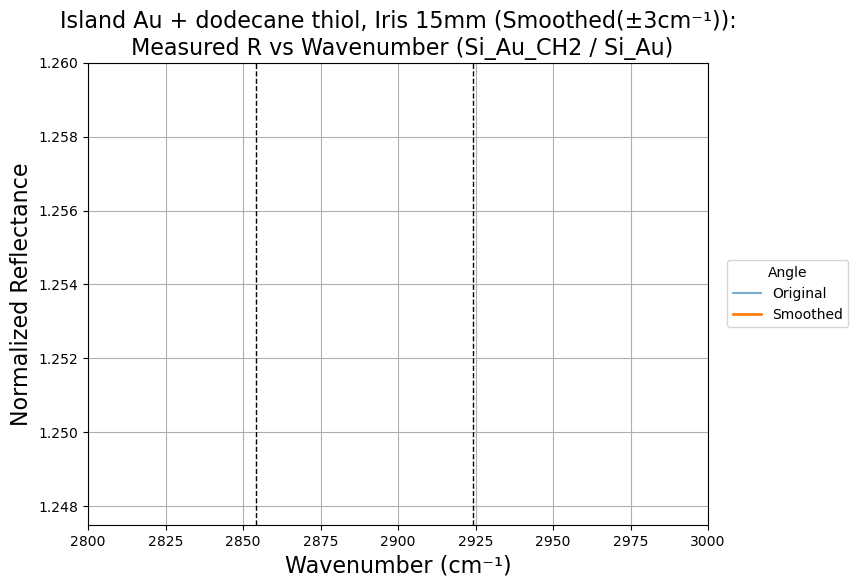

In [23]:
plt.figure(figsize=(8, 6))
plt.plot(wn_array, r_avg, label='Original',alpha=0.6)
plt.plot(wn_array, r_avg_smooth, label='Smoothed', linewidth=2)

plt.grid(True)
plt.axvline(2854, color='black', linestyle='--', linewidth=1)
plt.axvline(2924, color='black', linestyle='--', linewidth=1)
plt.xlim(2800, 3000)
plt.ylim(1.2475, 1.26)
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
plt.title(f"Island Au + dodecane thiol, Iris 15mm (Smoothed(±{window}cm⁻¹)):\n Measured R vs Wavenumber (Si_Au_CH2 / Si_Au)", fontsize = 16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize = 16)
plt.ylabel("Normalized Reflectance", fontsize = 16)
plt.show()

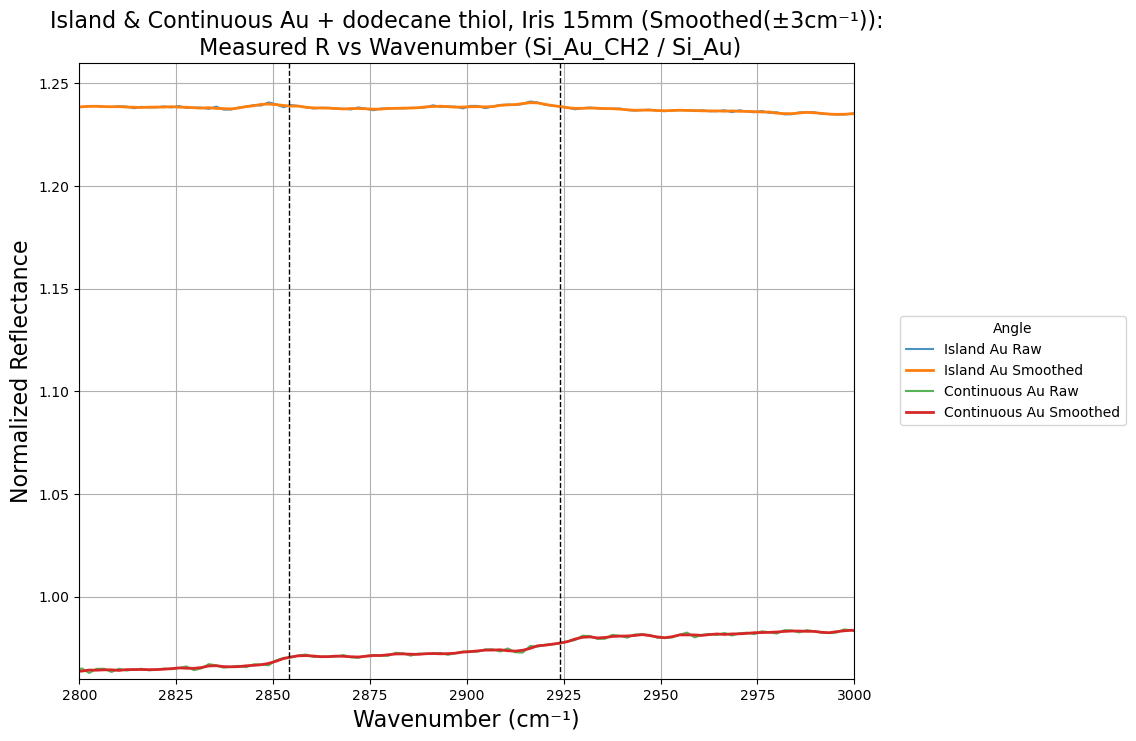

In [24]:
plt.figure(figsize=(10, 8))
plt.plot(wn_array, r_avg, label='Island Au Raw',alpha=0.8)
plt.plot(wn_array, r_avg_smooth, label='Island Au Smoothed', linewidth=2)

plt.plot(wn_array, r_avg_con, label='Continuous Au Raw',alpha=0.8)
plt.plot(wn_array, r_avg_smooth_con, label='Continuous Au Smoothed', linewidth=2)

plt.grid(True)
plt.axvline(2854, color='black', linestyle='--', linewidth=1)
plt.axvline(2924, color='black', linestyle='--', linewidth=1)
plt.xlim(2800, 3000)
plt.ylim(0.96, 1.26)
plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.title(f"Island & Continuous Au + dodecane thiol, Iris 15mm (Smoothed(±{window}cm⁻¹)):\n Measured R vs Wavenumber (Si_Au_CH2 / Si_Au)", fontsize = 16)
plt.xlabel("Wavenumber (cm⁻¹)", fontsize = 16)
plt.ylabel("Normalized Reflectance", fontsize = 16)
plt.show()

/var/folders/yp/lsrcw7px67qbghh0bc2zppfr0000gn/T/ipykernel_8065/1100128828.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


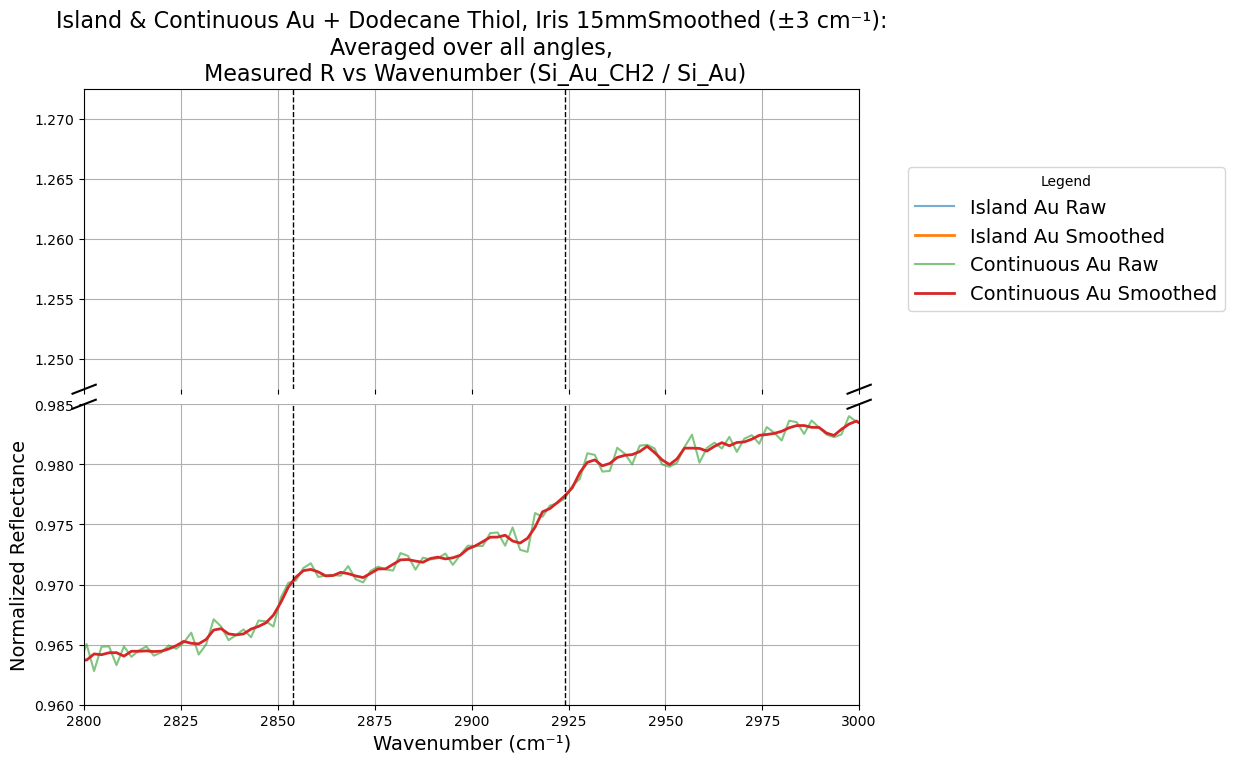

In [25]:
# --- Create subplots with broken y-axis ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})

# --- Plot both on upper and lower axes ---
for ax in [ax1, ax2]:
    ax.plot(wn_array, r_avg, label='Island Au Raw', alpha=0.6)
    ax.plot(wn_array, r_avg_smooth, label='Island Au Smoothed', linewidth=2)
    ax.plot(wn_array, r_avg_con, label='Continuous Au Raw', alpha=0.6)
    ax.plot(wn_array, r_avg_smooth_con, label='Continuous Au Smoothed', linewidth=2)

    ax.axvline(2854, color='black', linestyle='--', linewidth=1)
    ax.axvline(2924, color='black', linestyle='--', linewidth=1)
    ax.grid(True)

# --- Set x and y limits ---
ax1.set_ylim(1.2475, 1.2475+0.025)  # Top zoom
ax2.set_ylim(0.96, 0.985)  # Bottom zoom
ax2.set_xlim(2800, 3000)

# --- Hide spines between axes ---
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # no labels on upper x-axis
ax2.xaxis.tick_bottom()

# --- Diagonal break marks ---
d = .015  # size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to bottom axis
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# --- Labels and legend ---
ax1.legend(title="Legend", loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=14)
ax2.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
ax2.set_ylabel("Normalized Reflectance", fontsize=14)
ax1.set_title(f"Island & Continuous Au + Dodecane Thiol, Iris 15mmSmoothed (±{window} cm⁻¹):\nAveraged over all angles,\n Measured R vs Wavenumber (Si_Au_CH2 / Si_Au)", fontsize=16)

plt.tight_layout()
plt.show()


------Angular averaged------

In [26]:
# --- Angle Smoothing window  ---
window_angle = 6

# --- Extract sorted angle list and wavenumbers ---
angles_all = np.array(sorted(data_normed.keys()))
wavenumbers = np.array(data_normed[angles_all[0]]['wavenumber'].values)

# --- Create smoothed Rnorm matrix ---
Rnorm_angleavg_island = []
Rnorm_angleavg_con = []


for angle in angles_all:
    # Indices of angles within ±window degrees
    neighbor_mask = (angles_all >= angle - window) & (angles_all <= angle + window)
    neighbor_angles = angles_all[neighbor_mask]

    # Average Rnorm across neighbors
    Rnorm_avg_con = np.mean([data_normed_con[a]['Normed R'].values for a in neighbor_angles], axis=0)
    Rnorm_angleavg_con.append(Rnorm_avg_con)

    Rnorm_avg_island = np.mean([data_normed[a]['Normed R'].values for a in neighbor_angles], axis=0)
    Rnorm_angleavg_island.append(Rnorm_avg_island)

# Convert to array
Rnorm_angleavg_island = np.array(Rnorm_angleavg_island)
Rnorm_angleavg_con = np.array(Rnorm_angleavg_con)

In [27]:
# # --- SELECT angles
# selected_angles = [11,23,40] 
# # selected_angles = all_angles
# # selected_angles = anglelist

# plt.figure(figsize=(11, 6))

# for angle in selected_angles:
#     idx = angle - 5  # because 5° corresponds to index 0
#     R_island = Rnorm_angleavg_island[idx]
#     R_con = Rnorm_angleavg_con[idx]
#     plt.plot(wavenumbers, R_island, label=f"{angle}° Au island", linewidth=1.5,linestyle = '-.', alpha = 0.8)
#     plt.plot(wavenumbers, R_con, label=f"{angle}° Au continuous", linewidth=2, alpha = 0.5)

# plt.title(f"Island Au + dodecane thiol, Iris 15mm (Smoothed(±{window}cm⁻¹))\n Angle smoothed±{window_angle}°:\n Measured R vs Wavenumber (Si_Au_CH2 / Si_Au)", fontsize = 16)
# plt.xlabel("Wavenumber (cm⁻¹)", fontsize=14)
# plt.ylabel("Reflectance", fontsize=14)
# plt.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))
# plt.axvline(2854, color='black', linestyle='--', linewidth=1)
# plt.axvline(2924, color='black', linestyle='--', linewidth=1)
# plt.grid(True)
# plt.xlim(2800, 3000)
# plt.ylim(0.9, 1.3)
# plt.tight_layout(rect=[0, 0, 0.8, 1])
# plt.show()


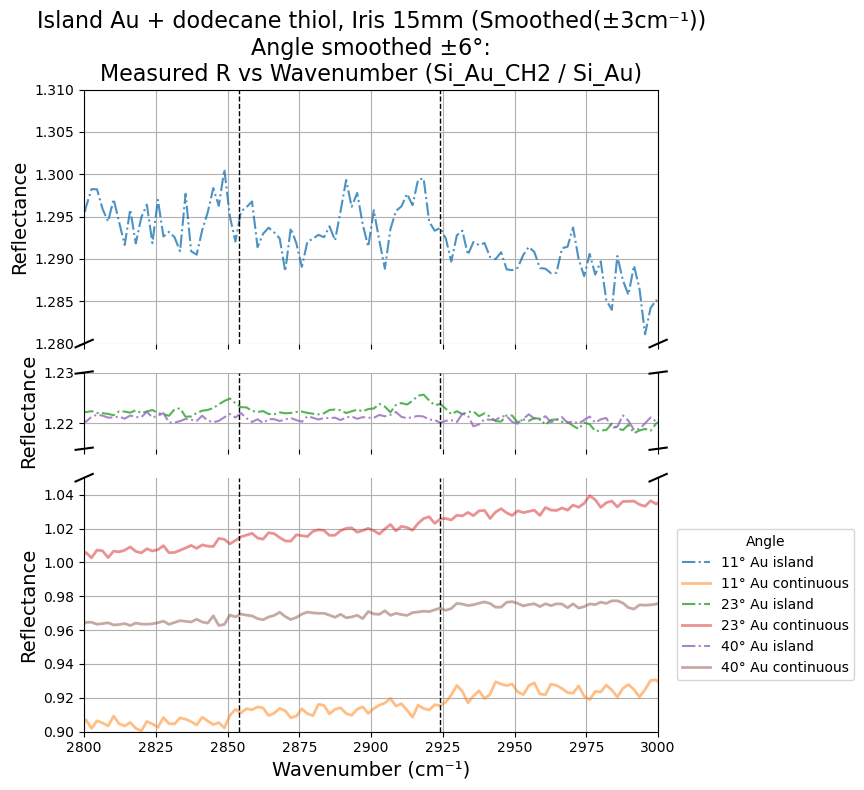

In [28]:
import matplotlib.pyplot as plt

selected_angles = [11, 23, 40]

# Create 3 vertically stacked axes
fig, (ax_top, ax_mid, ax_bot) = plt.subplots(3, 1, sharex=True, figsize=(11, 8),
                                              gridspec_kw={'height_ratios': [1, 0.3, 1]})

# Plot curves on all 3 axes
for i, angle in enumerate(selected_angles):
    idx = angle - 5
    R_island = Rnorm_angleavg_island[idx]
    R_con = Rnorm_angleavg_con[idx]

    # Style consistent across all plots
    ax_top.plot(wavenumbers, R_island, linestyle='-.', linewidth=1.5, alpha=0.8)
    ax_top.plot(wavenumbers, R_con, linestyle='-', linewidth=2, alpha=0.5)

    ax_mid.plot(wavenumbers, R_island, linestyle='-.', linewidth=1.5, alpha=0.8)
    ax_mid.plot(wavenumbers, R_con, linestyle='-', linewidth=2, alpha=0.5)

    ax_bot.plot(wavenumbers, R_island, linestyle='-.', linewidth=1.5, alpha=0.8, label=f"{angle}° Au island")
    ax_bot.plot(wavenumbers, R_con, linestyle='-', linewidth=2, alpha=0.5, label=f"{angle}° Au continuous")

# Set y-limits for each subplot
ax_top.set_ylim(1.28, 1.31)
ax_mid.set_ylim(1.215, 1.23)
ax_bot.set_ylim(0.9, 1.05)

# Hide spines between axes and add break indicators
for ax in [ax_top, ax_mid]:
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(labelbottom=False)

for ax in [ax_mid, ax_bot]:
    ax.spines['top'].set_visible(False)

d = .015  # size of diagonal lines for breaks

# Diagonals
def break_lines(ax1, ax2):
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)

    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

break_lines(ax_top, ax_mid)
break_lines(ax_mid, ax_bot)

# Axvlines and formatting for all
for ax in (ax_top, ax_mid, ax_bot):
    ax.axvline(2854, color='black', linestyle='--', linewidth=1)
    ax.axvline(2924, color='black', linestyle='--', linewidth=1)
    ax.grid(True)
    ax.set_xlim(2800, 3000)

# Labels and title
ax_bot.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
ax_top.set_ylabel("Reflectance", fontsize=14)
ax_mid.set_ylabel("Reflectance", fontsize=14)
ax_bot.set_ylabel("Reflectance", fontsize=14)

ax_top.set_title(f"Island Au + dodecane thiol, Iris 15mm (Smoothed(±{window}cm⁻¹))\n"
                 f"Angle smoothed ±{window_angle}°:\nMeasured R vs Wavenumber (Si_Au_CH2 / Si_Au)", fontsize=16)

# Legend on bottom
ax_bot.legend(title="Angle", loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


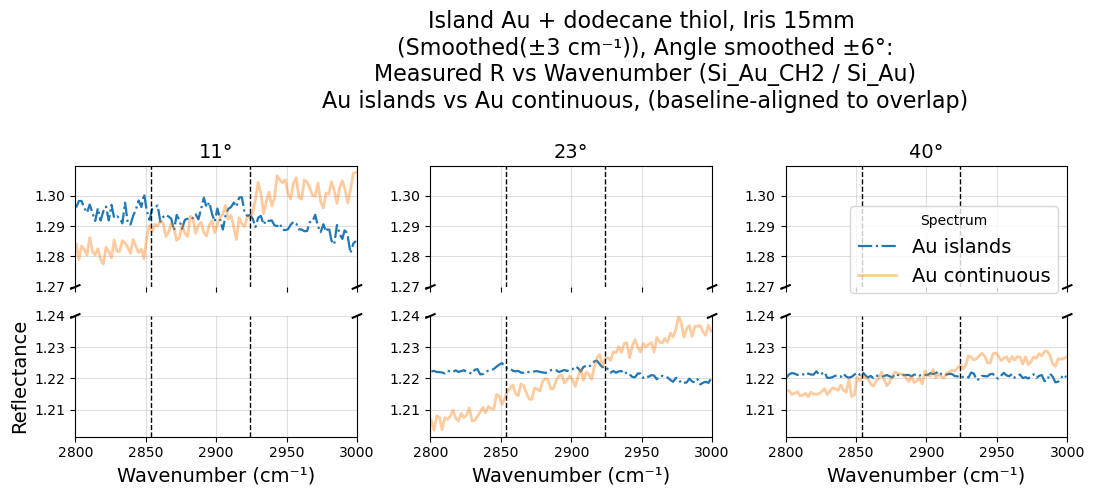

In [29]:
import numpy as np
import matplotlib.pyplot as plt

selected_angles = [11, 23, 40]
ch2_min, ch2_max = 2800, 3000
baseline_bands = [(2800, 2840), (2960, 3000)]
cut_low, cut_high = 1.24, 1.27  # range to cut out

def band_mask(x, lo, hi):
    return (x >= lo) & (x <= hi)

baseline_mask = np.zeros_like(wavenumbers, dtype=bool)
for lo, hi in baseline_bands:
    baseline_mask |= band_mask(wavenumbers, lo, hi)

ch2_mask = band_mask(wavenumbers, ch2_min, ch2_max)

aligned_data_by_angle = {}
all_vals_for_limits = []

# Align baselines
for angle in selected_angles:
    idx = angle - 5
    R_island = np.asarray(Rnorm_angleavg_island[idx])
    R_con    = np.asarray(Rnorm_angleavg_con[idx])
    base_island = np.median(R_island[baseline_mask])
    base_con    = np.median(R_con[baseline_mask])
    delta = base_con - base_island
    R_con_aligned = R_con - delta
    R_island_aligned = R_island.copy()
    aligned_data_by_angle[angle] = (R_island_aligned, R_con_aligned)
    all_vals_for_limits.append(R_island_aligned[ch2_mask])
    all_vals_for_limits.append(R_con_aligned[ch2_mask])

all_vals_for_limits = np.concatenate(all_vals_for_limits)
y_min = np.nanmin(all_vals_for_limits)
y_max = np.nanmax(all_vals_for_limits)
pad = 0.02 * (y_max - y_min)
lower_ylim = (y_min - pad, cut_low)
upper_ylim = (cut_high, y_max + pad)

# Create figure with broken y-axis for each angle
fig, axes = plt.subplots(
    2, len(selected_angles), figsize=(13, 5),
    sharex='col', sharey=False, gridspec_kw={'height_ratios': [1, 1]}
)
if len(selected_angles) == 1:
    axes = np.array([[axes[0]], [axes[1]]])  # keep 2D shape

for col, angle in enumerate(selected_angles):
    ax_upper = axes[0, col]
    ax_lower = axes[1, col]
    R_island_aligned, R_con_aligned = aligned_data_by_angle[angle]

    # Plot only CH2 range
    ax_upper.plot(wavenumbers[ch2_mask], R_island_aligned[ch2_mask], 
                  '-.', linewidth=1.6, alpha=1, label="Au islands")
    ax_upper.plot(wavenumbers[ch2_mask], R_con_aligned[ch2_mask], 
                  '-', linewidth=2.0, alpha=0.4, label="Au continuous")

    ax_lower.plot(wavenumbers[ch2_mask], R_island_aligned[ch2_mask], 
                  '-.', linewidth=1.6, alpha=1)
    ax_lower.plot(wavenumbers[ch2_mask], R_con_aligned[ch2_mask], 
                  '-', linewidth=2.0, alpha=0.4)
        # --- Add CH₂ peak marker lines ---
    for ax in (ax_upper, ax_lower):
        ax.axvline(2854, color='black', linestyle='--', linewidth=1)
        ax.axvline(2924, color='black', linestyle='--', linewidth=1)


    # Set limits
    ax_upper.set_ylim(*upper_ylim)
    ax_lower.set_ylim(*lower_ylim)

    # Hide the spines between
    ax_upper.spines['bottom'].set_visible(False)
    ax_lower.spines['top'].set_visible(False)
    ax_upper.tick_params(labelbottom=False)

    # Diagonal break marks
    d = .015
    kwargs = dict(transform=ax_upper.transAxes, color='k', clip_on=False)
    ax_upper.plot((-d, +d), (-d, +d), **kwargs)
    ax_upper.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_lower.transAxes)
    ax_lower.plot((-d, +d), (1 - d, 1 + d), **kwargs)
    ax_lower.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

    # Formatting
    ax_upper.set_xlim(ch2_min, ch2_max)
    ax_lower.set_xlim(ch2_min, ch2_max)
    ax_lower.grid(True, alpha=0.4)
    ax_upper.grid(True, alpha=0.4)
    ax_lower.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
    if col == 0:
        ax_lower.set_ylabel("Reflectance", fontsize=14)
    ax_upper.set_title(f"{angle}°", fontsize=14)

# One legend for the whole figure
handles, labels = axes[0, -1].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.65, 0.5), title="Spectrum",fontsize=14)

fig.suptitle(
    f"Island Au + dodecane thiol, Iris 15mm \n"
    f"(Smoothed(±{window} cm⁻¹)), Angle smoothed ±{window_angle}°:\n"
    f"Measured R vs Wavenumber (Si_Au_CH2 / Si_Au)\n"
    f"Au islands vs Au continuous, "
    f"(baseline-aligned to overlap)",
    fontsize=16)
plt.tight_layout(rect=[0, 0, 0.85, 0.98])
plt.show()


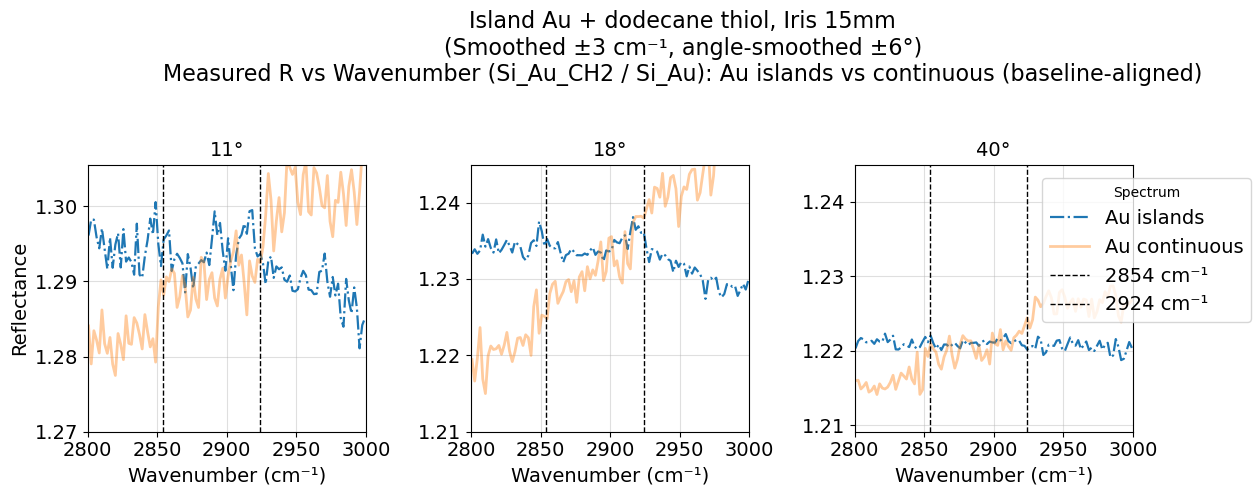

In [46]:

selected_angles = [11, 18, 40]
ch2_min, ch2_max = 2800, 3000
baseline_bands = [(2800, 2840), (2960, 3000)]

def band_mask(x, lo, hi):
    return (x >= lo) & (x <= hi)

baseline_mask = np.zeros_like(wavenumbers, dtype=bool)
for lo, hi in baseline_bands:
    baseline_mask |= band_mask(wavenumbers, lo, hi)

ch2_mask = band_mask(wavenumbers, ch2_min, ch2_max)

aligned_data_by_angle = {}

# Align baselines
for angle in selected_angles:
    idx = angle - 5
    R_island = np.asarray(Rnorm_angleavg_island[idx])
    R_con    = np.asarray(Rnorm_angleavg_con[idx])
    base_island = np.median(R_island[baseline_mask])
    base_con    = np.median(R_con[baseline_mask])
    delta = base_con - base_island
    R_con_aligned = R_con - delta
    R_island_aligned = R_island.copy()
    aligned_data_by_angle[angle] = (R_island_aligned, R_con_aligned)

# Create single-row subplots
fig, axes = plt.subplots(1, len(selected_angles), figsize=(14, 5), sharex=True)

for col, angle in enumerate(selected_angles):
    ax = axes[col]
    R_island_aligned, R_con_aligned = aligned_data_by_angle[angle]

    # Plot reflectance in CH2 region
    ax.plot(wavenumbers[ch2_mask], R_island_aligned[ch2_mask], 
            '-.', linewidth=1.6, alpha=1, label="Au islands")
    ax.plot(wavenumbers[ch2_mask], R_con_aligned[ch2_mask], 
            '-', linewidth=2.0, alpha=0.4, label="Au continuous")

    # CH2 peak markers
    ax.axvline(2854, color='black', linestyle='--', linewidth=1, label='2854 cm⁻¹' if col == 0 else "")
    ax.axvline(2924, color='black', linestyle='--', linewidth=1, label='2924 cm⁻¹' if col == 0 else "")

    ax.set_xlim(ch2_min, ch2_max)
    ax.grid(True, alpha=0.4)
    ax.set_title(f"{angle}°", fontsize=14)
    ax.tick_params(labelsize=14)

    # Set custom y-limits
    if angle == 11:
        ax.set_ylim(1.27, np.max(R_island_aligned[ch2_mask]) + 0.005)
    else:
        ax.set_ylim(np.min(R_con_aligned[ch2_mask]) - 0.005, 1.245)

    # Axis labels
    if col == 0:
        ax.set_ylabel("Reflectance", fontsize=14)
    ax.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)

# One shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.75, 0.5), title="Spectrum", fontsize=14)

# Title
fig.suptitle(
    f"Island Au + dodecane thiol, Iris 15mm\n"
    f"(Smoothed ±{window} cm⁻¹, angle-smoothed ±{window_angle}°)\n"
    f"Measured R vs Wavenumber (Si_Au_CH2 / Si_Au): Au islands vs continuous (baseline-aligned)",
    fontsize=16
)

plt.tight_layout(rect=[0, 0, 0.85, 0.93])
plt.show()


In [31]:
R_matrix = np.vstack(Rnorm_angleavg_island)  
R_avg_angleavg_island = np.nanmean(R_matrix, axis=0) 
R_matrix = np.vstack(Rnorm_angleavg_con) 
R_avg_angleavg_con = np.nanmean(R_matrix, axis=0)  

In [32]:
window = 3  # ±3 cm⁻¹

def smooth_by_wavenumber(data, wn_array, window):
    smoothed = []
    for i, center_wn in enumerate(wn_array):
        mask = (wn_array >= center_wn - window) & (wn_array <= center_wn + window)
        valid = ~np.isnan(data[mask])
        avg = np.mean(data[mask][valid]) if np.any(valid) else np.nan
        smoothed.append(avg)
    return np.array(smoothed)

# --- Perform smoothing ---
r_avg_smooth_angleavg      = smooth_by_wavenumber(R_avg_angleavg_island, wavenumbers, window)
r_avg_smooth_con_angleavg  = smooth_by_wavenumber(R_avg_angleavg_con, wavenumbers, window)

/var/folders/yp/lsrcw7px67qbghh0bc2zppfr0000gn/T/ipykernel_8065/1701654474.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


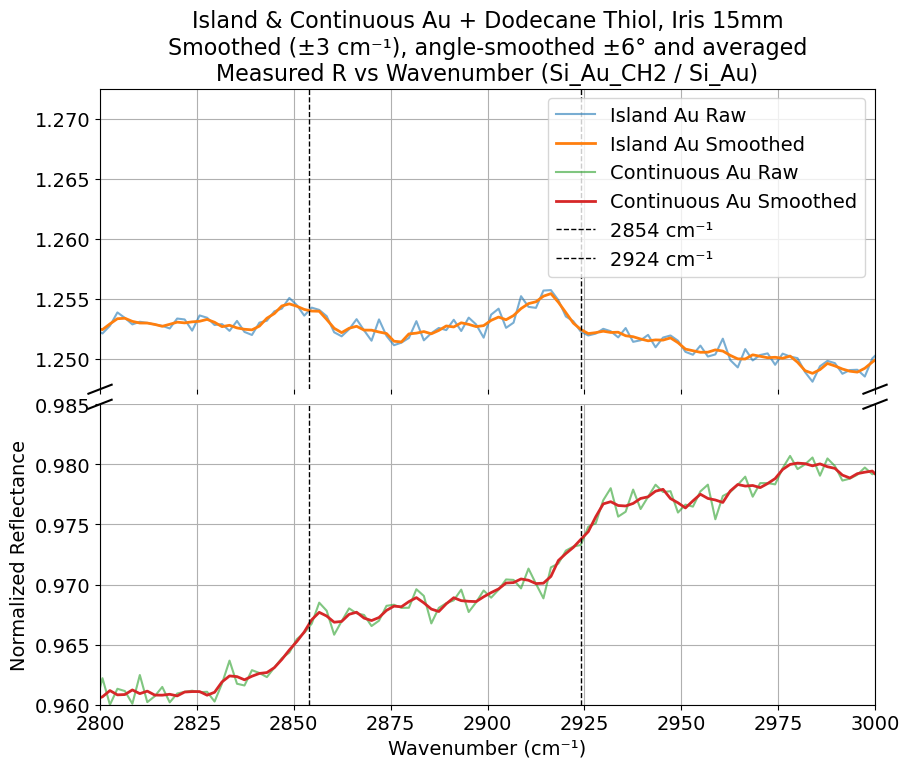

In [36]:
# --- Create subplots with broken y-axis ---
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.05})

# --- Plot both on upper and lower axes ---
for ax in [ax1, ax2]:
    line1, = ax.plot(wn_array, R_avg_angleavg_island, label='Island Au Raw', alpha=0.6)
    line2, = ax.plot(wn_array, r_avg_smooth_angleavg, label='Island Au Smoothed', linewidth=2)
    line3, = ax.plot(wn_array, R_avg_angleavg_con, label='Continuous Au Raw', alpha=0.6)
    line4, = ax.plot(wn_array, r_avg_smooth_con_angleavg, label='Continuous Au Smoothed', linewidth=2)

    vline1 = ax.axvline(2854, color='black', linestyle='--', linewidth=1, label='2854 cm⁻¹')
    vline2 = ax.axvline(2924, color='black', linestyle='--', linewidth=1, label='2924 cm⁻¹')
    
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=14)  # Set axis number fontsize = 14

# --- Set x and y limits ---
ax1.set_ylim(1.2475, 1.2725)  # Top zoom
ax2.set_ylim(0.96, 0.985)  # Bottom zoom
ax2.set_xlim(2800, 3000)

# --- Hide spines between axes ---
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)  # no labels on upper x-axis
ax2.xaxis.tick_bottom()

# --- Diagonal break marks ---
d = .015  # size of diagonal lines
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to bottom axis
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# --- Labels and legend ---
handles = [line1, line2, line3, line4, vline1, vline2]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, fontsize=14)

ax2.set_xlabel("Wavenumber (cm⁻¹)", fontsize=14)
ax2.set_ylabel("Normalized Reflectance", fontsize=14)
ax1.set_title(f"Island & Continuous Au + Dodecane Thiol, Iris 15mm\nSmoothed (±{window} cm⁻¹), angle-smoothed ±{window_angle}° and averaged\nMeasured R vs Wavenumber (Si_Au_CH2 / Si_Au)", fontsize=16)

plt.tight_layout()
plt.show()
